In [1]:
import os
import warnings
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import TqdmExperimentalWarning
from datetime import timedelta
from matplotlib.dates import DateFormatter
from traffic.core import Traffic

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

agg_functions = ['min', 'max', 'mean']

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /Users/bikram/Work/clients/c-bik/repos/opensky-prc-atow-pred-challenge/notebooks


# Load Challenge and Final Submission Set Data

In [2]:
challenge_data = pd.read_csv("../data/challenge_set.csv")
submission_data = pd.read_csv("../data/final_submission_set.csv")
print(f"{challenge_data.shape[0]=}, {submission_data.shape[0]=}")

# Concatenate both into a single df
challenge_data = pd.concat([challenge_data, submission_data], axis=0)
challenge_data.reset_index(drop=True, inplace=True)
print(f"{challenge_data.shape[0]=}")

# Calculate takeoff time (actual_offblock_time + taxiout_time)
challenge_data['takeoff_time'] = pd.to_datetime(challenge_data['actual_offblock_time'], utc=True) + pd.to_timedelta(challenge_data['taxiout_time'], unit='m')
challenge_data['takeoff_time'] = challenge_data['takeoff_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

print(challenge_data.dtypes)
print(f"{challenge_data[['flight_id']].drop_duplicates().shape[0]=}")
challenge_data[['flight_id','date','actual_offblock_time','taxiout_time','takeoff_time','arrival_time','flight_duration','flown_distance']]

challenge_data.shape[0]=369013, submission_data.shape[0]=158149
challenge_data.shape[0]=527162
flight_id                 int64
date                     object
callsign                 object
adep                     object
name_adep                object
country_code_adep        object
ades                     object
name_ades                object
country_code_ades        object
actual_offblock_time     object
arrival_time             object
aircraft_type            object
wtc                      object
airline                  object
flight_duration           int64
taxiout_time              int64
flown_distance            int64
tow                     float64
takeoff_time             object
dtype: object
challenge_data[['flight_id']].drop_duplicates().shape[0]=527162


,flight_id,date,actual_offblock_time,taxiout_time,takeoff_time,arrival_time,flight_duration,flown_distance
0,248763780,2022-01-01,2022-01-01T13:46:00Z,18,2022-01-01T14:04:00Z,2022-01-01T15:04:56Z,61,321
1,248760618,2022-01-01,2022-01-01T09:55:00Z,13,2022-01-01T10:08:00Z,2022-01-01T19:37:56Z,570,4193
2,248753824,2022-01-01,2022-01-01T09:39:00Z,15,2022-01-01T09:54:00Z,2022-01-01T19:08:13Z,554,3770
3,248753852,2022-01-01,2022-01-01T11:04:00Z,11,2022-01-01T11:15:00Z,2022-01-01T19:32:13Z,497,3607
4,248755934,2022-01-01,2022-01-01T12:36:00Z,14,2022-01-01T12:50:00Z,2022-01-01T13:44:32Z,55,305
...,...,...,...,...,...,...,...,...
527157,258068876,2022-12-31,2022-12-31T09:25:00Z,25,2022-12-31T09:50:00Z,2022-12-31T12:24:24Z,154,988
527158,258064675,2022-12-31,2022-12-31T10:04:21Z,9,2022-12-31T10:13:21Z,2022-12-31T10:55:35Z,42,240
527159,258065436,2022-12-31,2022-12-31T09:34:00Z,14,2022-12-31T09:48:00Z,2022-12-31T17:51:22Z,483,3426
527160,258058138,2022-12-31,2022-12-31T09:37:00Z,15,2022-12-31T09:52:00Z,2022-12-31T10:47:00Z,55,335


# Load _ALL_ `parquet` files

In [3]:
ddf = dd.read_parquet('../data/*.parquet')
ddf['flight_id'] = ddf['flight_id'].astype('int64')
print(ddf.dtypes)
ddf.head()

flight_id                            int64
timestamp              datetime64[ns, UTC]
latitude                           float64
longitude                          float64
altitude                           float64
groundspeed                        float64
track                              float64
vertical_rate                      float64
icao24                               int64
u_component_of_wind                float64
v_component_of_wind                float64
temperature                        float64
specific_humidity                  float64
dtype: object


,flight_id,timestamp,latitude,longitude,altitude,groundspeed,track,vertical_rate,icao24,u_component_of_wind,v_component_of_wind,temperature,specific_humidity
0,248763775,2022-01-01 18:14:38+00:00,30.898407,31.240270,38000.0,429.0,350.888643,-64.0,248763775,8.754636,-13.070078,221.819618,0.000008
1,248763775,2022-01-01 18:14:39+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.696749,-13.106524,221.794782,0.000008
2,248763775,2022-01-01 18:14:40+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697087,-13.107184,221.794700,0.000008
3,248763775,2022-01-01 18:14:41+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697424,-13.107845,221.794618,0.000008
4,248763775,2022-01-01 18:14:42+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697762,-13.108505,221.794536,0.000008


# Clean Flight data

Keep only the in-the-air portion of the trajectory data

### Ref: [Trajectory](https://ansperformance.eu/study/data-challenge/data.html#trajectory)
> Trajectories are not necessarily complete/overlapping with respect to what reported in the flight list in actual_offblock_time or arrival_time. This is due to the possibly limited/partial ADS-B coverage in some parts (or some lower altitudes) of the world. The interval [actual_offblock_time + taxiout_time, arrival_time] is a good approximation of the in-the-air portion of the flight.

### Ref: [Exploratory Data Analysis](https://ansperformance.eu/study/data-challenge/data.html#using-traffic-for-exploratory-data-analysis)
> Consider only the `[actual_offblock_time + taxiout_time, arrival_time]` interval for the in-the-air portion of the flight.

In [4]:
print(f"{challenge_data[['flight_id']].drop_duplicates().shape[0]=}")
time_ddf = dd.from_pandas(challenge_data)
time_ddf['takeoff_time'] = dd.to_datetime(time_ddf['takeoff_time'], utc=True)
time_ddf['arrival_time'] = dd.to_datetime(time_ddf['arrival_time'], utc=True)
merged_ddf = ddf.merge(time_ddf, on='flight_id', how='inner')
print(f"{merged_ddf[['flight_id']].drop_duplicates().compute().shape[0]=}")
filtered_ddf = merged_ddf[
    (merged_ddf['timestamp'] >= merged_ddf['takeoff_time']) &
    (merged_ddf['timestamp'] <= merged_ddf['arrival_time'])
]
print(f"{filtered_ddf[['flight_id']].drop_duplicates().compute().shape[0]=}")
# print(filtered_ddf.dtypes)
# filtered_ddf.head()

flight_id                             int64
timestamp               datetime64[ns, UTC]
latitude                            float64
longitude                           float64
altitude                            float64
groundspeed                         float64
track                               float64
vertical_rate                       float64
icao24                                int64
u_component_of_wind                 float64
v_component_of_wind                 float64
temperature                         float64
specific_humidity                   float64
date                        string[pyarrow]
callsign                    string[pyarrow]
adep                        string[pyarrow]
name_adep                   string[pyarrow]
country_code_adep           string[pyarrow]
ades                        string[pyarrow]
name_ades                   string[pyarrow]
country_code_ades           string[pyarrow]
actual_offblock_time        string[pyarrow]
arrival_time            datetime

,flight_id,timestamp,latitude,longitude,altitude,groundspeed,track,vertical_rate,icao24,u_component_of_wind,...,actual_offblock_time,arrival_time,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow,takeoff_time
0,248763780,2022-01-01 14:04:41+00:00,51.477651,-0.443802,25.0,NaN,NaN,NaN,248763780,2.329204,...,2022-01-01T13:46:00Z,2022-01-01 15:04:56+00:00,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.0,2022-01-01 14:04:00+00:00
1,248763780,2022-01-01 14:04:42+00:00,51.477651,-0.443802,25.0,NaN,NaN,NaN,248763780,2.329413,...,2022-01-01T13:46:00Z,2022-01-01 15:04:56+00:00,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.0,2022-01-01 14:04:00+00:00
2,248763780,2022-01-01 14:04:43+00:00,51.477651,-0.443802,25.0,NaN,NaN,NaN,248763780,2.329622,...,2022-01-01T13:46:00Z,2022-01-01 15:04:56+00:00,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.0,2022-01-01 14:04:00+00:00
3,248763780,2022-01-01 14:04:44+00:00,51.477651,-0.443802,25.0,NaN,NaN,NaN,248763780,2.329831,...,2022-01-01T13:46:00Z,2022-01-01 15:04:56+00:00,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.0,2022-01-01 14:04:00+00:00
4,248763780,2022-01-01 14:04:45+00:00,51.477651,-0.443802,25.0,NaN,NaN,NaN,248763780,2.330040,...,2022-01-01T13:46:00Z,2022-01-01 15:04:56+00:00,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.0,2022-01-01 14:04:00+00:00


# Compute `density altitude`
**Formula:** $\text{Density Altitude} = \text{Pressure Altitude} + \left[120 \times (\text{Outside Air Temperature (OAT)} - \text{Standard Temperature at Altitude})\right]$

Where:
- **Pressure Altitude** is the altitude corrected for atmospheric pressure variations, which can be approximated by the recorded altitude in aviation.
- **Standard Temperature at Altitude** is typically calculated as: $\text{Standard Temperature at Altitude} = 15°C - (2°C \times (\text{Altitude (in thousands of feet)}))$

This assumes that the temperature decreases by 2°C for every 1,000 feet of altitude.

In [ ]:
# Step 0: fill missing temperature data
filtered_ddf['temperature'] = filtered_ddf['temperature'].bfill()

# Step 1: Convert altitude from meters to feet
# filtered_ddf['altitude_ft'] = filtered_ddf['altitude'] * 3.28084

# Step 2: Convert temperature from Kelvin to Celsius
filtered_ddf['temperature_celsius'] = filtered_ddf['temperature'] - 273.15

# Step 3: Calculate the standard temperature at altitude (in degrees Celsius)
# Standard temperature at sea level is 15°C, and it decreases by 2°C for every 1000 feet
filtered_ddf['standard_temp_at_alt'] = 15 - (2 * (filtered_ddf['altitude'] / 1000))

# Step 4: Calculate the density altitude
# Density Altitude = Pressure Altitude + 120 * (OAT - Standard Temp at Altitude)
filtered_ddf['density_altitude'] = filtered_ddf['altitude'] + 120 * (filtered_ddf['temperature_celsius'] - filtered_ddf['standard_temp_at_alt'])

# Step 5: Inspect the result
filtered_ddf[['flight_id', 'altitude', 'temperature', 'density_altitude']].head()

In [ ]:
aggregated_ddf = filtered_ddf.groupby('flight_id')[['density_altitude']].agg(agg_functions)
aggregated_ddf = aggregated_ddf.compute()
aggregated_ddf.head()

In [ ]:
aggregated_ddf.columns = ['_'.join(col).strip() for col in aggregated_ddf.columns.values]
aggregated_ddf.head()

In [ ]:
aggregated_ddf.to_csv('../data/density_altitude.csv')

# Compute `vertical_rate`
`vertical_rate [ft/min]` is rate of climb/descent ([Trajectory](https://ansperformance.eu/study/data-challenge/data.html#trajectory))

`climb_rate` is `vertical_rate` > 0 (assuming descent is negative)

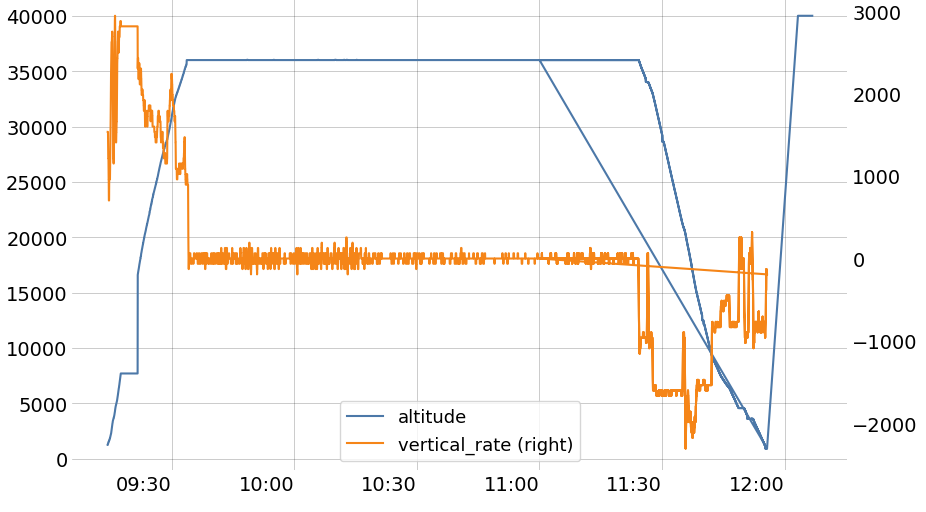

In [ ]:
filtered_ddf['flight_id'].head(10)

In [ ]:
filtered_ddf.dtypes

In [ ]:
aggregated_ddf0 = filtered_ddf[filtered_ddf.vertical_rate > 10].groupby('flight_id')[['vertical_rate']].agg(agg_functions)
aggregated_ddf0 = aggregated_ddf0.compute()
aggregated_ddf0.head()

In [ ]:
aggregated_ddf0.columns = ['_'.join(col).strip() for col in aggregated_ddf0.columns.values]
aggregated_ddf0.head()

In [ ]:
aggregated_ddf0.to_csv('../data/vertical_rate.csv')

# Aggregate

In [ ]:
# Define the columns you want to aggregate
columns_to_aggregate = [
    'altitude', 'groundspeed', 'track', 'vertical_rate', 
    'u_component_of_wind', 'v_component_of_wind', 
    'temperature', 'specific_humidity'
]

# Perform the groupby operation and aggregate per flight_id
aggregated_ddf = filtered_ddf.groupby('flight_id')[columns_to_aggregate].agg(agg_functions)

# Compute the result (this step triggers the actual computation)
aggregated_ddf = aggregated_ddf.compute()

# Display the first few rows to check the output
aggregated_ddf.head()

In [ ]:
aggregated_ddf.columns = ['_'.join(col).strip() for col in aggregated_ddf.columns.values]
aggregated_ddf.head()

In [ ]:
aggregated_ddf.to_csv('../data/additional_features.csv')

In [2]:
ddf = dd.read_parquet('../data_cleaned/*.parquet')
ddf['flight_id'] = ddf['flight_id'].astype('int64')
print(ddf.dtypes)
ddf.head()

flight_id                      int64
timestamp        datetime64[ns, UTC]
temperature                  float64
altitude                     float64
groundspeed                  float64
vertical_rate                float64
dtype: object


,flight_id,timestamp,temperature,altitude,groundspeed,vertical_rate
0,248750643,2022-01-01 05:32:38+00:00,280.874985,1475.0,151.0,2496.0
1,248750643,2022-01-01 05:32:39+00:00,280.898498,1525.0,153.0,2112.0
2,248750643,2022-01-01 05:32:40+00:00,280.908320,1550.0,153.0,2112.0
3,248750643,2022-01-01 05:32:41+00:00,280.908358,1550.0,154.0,1664.0
4,248750643,2022-01-01 05:32:42+00:00,280.908396,1550.0,155.0,1536.0
